In [22]:
import numpy as np

In [2]:
import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

#%R install.packages("Matching")
%R library(Matching)


R[write to console]: Loading required package: MASS

R[write to console]: ## 
##  Matching (Version 4.9-11, Build Date: 2021-10-18)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




'Matching','MASS','tools',...,'datasets','methods','base'


## Lalonde data

The study looked at the effectiveness of a job training program (the treatment) on the real earnings of an individual, a couple years after completion of the program.

The data consists of a number of demographic variables (age, race, academic background, and previous real earnings), as well as a treatment indicator, and the real earnings in the year 1978 (the response).

Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620



In [3]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)

In [4]:
lalonde.head(5)

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
1,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,True
2,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,True
3,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,True
4,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,True
5,33,8,1,0,0,1,0.0,0.0,289.79,1,1,True


In [26]:
mean_per_treatment = lalonde.groupby('treat').agg({"re78":np.mean}).reset_index()

In [27]:
mean_per_treatment

,treat,re78
0,False,4554.802283
1,True,6349.145368


- Let $Y$ be the outcome variable re78 which is the real earnings in 1978
- Let $X$ be the age in years
- Let $T$ be the treatment which stands for participating in job training program

Naive estimator: $\bar{Y}_{treatment}-\bar{Y}_{control}$

In [33]:
mean_treatment = float(mean_per_treatment.query("treat==True")['re78'])
mean_control = float(mean_per_treatment.query("treat==False")['re78'])
mean_treatment-mean_control

## Build the graph

In [14]:
graph = 'digraph {age->re78;age->treat;treat->re78}'

In [15]:
model = CausalModel(
    data=lalonde,
    treatment='treat',
    outcome='re78',
    graph=graph)

## View the graph

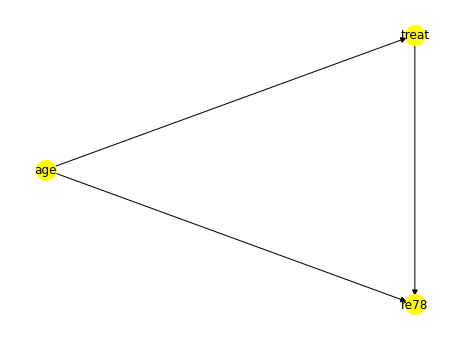

In [16]:
model.view_model()

In [17]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

## Estimate via linear regression by identifying using backdoor criterion

In [18]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

### Model:  $Y_i = \mu_{.} + \tau T_i+\gamma X_i +\epsilon_i$
### Estimated model: $\hat{Y}_i = \hat{\mu}_{.} + \hat{\tau} t_i+\hat{\gamma} x_i$
### Estimand $\tau=\mathbb{E}(Y_i(1)-Y_i(0)) = \frac{1}{n} \sum^{n}_{i}\left( \mathbb{E}[Y_i|T_i=1, X_i]-\mathbb{E}[Y_i|T_i=0, X_i]\right)$ (by identification and model assumptions)


## Estimate of the  treatment effect estimator $\hat{\tau}$

In [19]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 1758.5747485110223


### Estimated treatment effect interpretaiton
With the same age levels for subjects who took the treatment we should expect around 1758.6 increase in average of the outcome (real earnings in 1978) 

# Appendix: regression theory for causal inference

- Let $Y_i$ be the outcome variable for the $i$th subject
- Let $X_i$ be the constant pre-treatment covariate for the $i$th subject
- Let $\tau=\mathbb{E}(Y_i(1)-Y_i(0))$ be the causal ATE estimand


\begin{align*}
&\mathbb{E}(Y(t)|X_i)=\mu_{.}+\tau T_i+\gamma X_i\\
&Y_i(0)=\mu_{.}+\gamma X_i +\epsilon_i\\
&Y_i(1)=Y_i(0) +\tau\\
\end{align*}


### It follows that $Y_i= T_iY_i(1)+(1-T_i)Y_i(0) = \mu_{.} + \tau T_i+\gamma X_i +\epsilon_i$


## Model assumptions
1. Linearity of regression relation of $Y_i$ with $X_{i}$
2. Exogeneity - $\epsilon_i \perp \!\!\! \perp T_i, X_i$
3. Positivity - $0<P(T_i=1|X_i=x_i)<1 \quad \forall x$
4. Parallel slopes (constant treatment effect $\tau$ across all values of $X_i$)

### Importance of exogeneity (which implies unconfoundedness)
In general
$$P(T_i=1|Y_i(0), Y_i(1), X_i)=P(T_i|\epsilon_i, X_i)$$
If exogeneity holds then $$P(T_i|\epsilon_i, X_i) = P(T_i|X_i)$$

### Importance of parallel slopes
Let us assume linearity and exogeneity assumptions are true,
also let us for the sake of illustration assume:
$$\mathbb{E}(Y(0))=\mu_0+\gamma_0X_i$$
$$\mathbb{E}(Y(1))=\mu_1+\gamma_1X_i$$

\begin{align*}
    &\mathbb{E}(Y_i|T_i, X_i)=\mathbb{E}(T_i \cdot Y_i(1) + (1-T_i)\cdot Y_i(0)|T_i, X_i)=\\
    &=\mu_0+T_i(\mu_1-\mu_{0})+\gamma_0 X_i + T_i(\gamma_1-\gamma_0)X_i
    \\
    \\
    &\tau = \mathbb{E}(Y_i|T_i=1, X_i)-\mathbb{E}(Y_i|T_i=0, X_i)=\\
    &(\mu_1-\mu_0)+X_i(\gamma_1-\gamma_0)
\end{align*}
Thus, $\tau$ is the causal ATE when the regression lines for the potential outcomes are parallel i.e. $\gamma_0=\gamma_1$.


## Identification

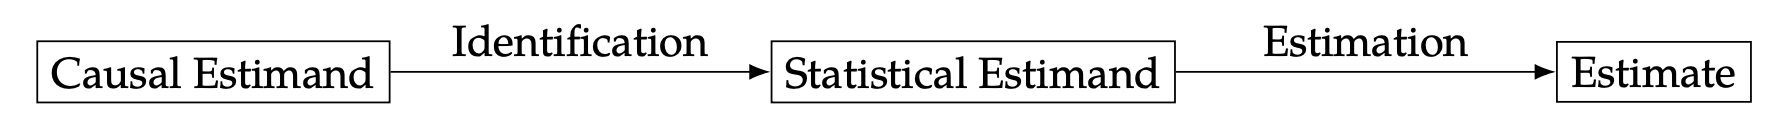

- Causal estimand: $\mathbb{E}(Y_i(1)-Y(0))$ 
- Identified statistical estimand: $\mathbb{E}_X[\mathbb{E}[Y_i|T_i=1, X_i]-\mathbb{E}[Y_i|T_i=0, X_i]]$ (given the modularity assumption, backdoor criterion and positivity assumption)
- Regression estimator: $\frac{1}{n} \sum^{n}_{i}[(\hat{\mu}_{.} + \hat{\tau} +\hat{\gamma} x_i)-(\hat{\mu}_{.} +\hat{\gamma} x_i)] = \hat{\tau}$